In [1]:
from nibabel.nifti1 import Nifti1Image
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import load_img
from nilearn import plotting
from nilearn import datasets
import pandas as pd
import numpy as np

from niseq import sequential_cluster_test_1samp

/home/johnv/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Let's say that we are willing to collect $n_\text{max} = 80$ subjects, but we want to check if we have enough evidence to stop early every 10 subjects. So far, we've collected 20 subjects, so it's time to check again. 

In [2]:
# fetch 20 subjects of brainomics localizer dataset
n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(
    n_subjects = n_samples, legacy_format = False
)
# and get contrasts
cmap_filenames = localizer_dataset.cmaps
imgs = [load_img(f) for f in cmap_filenames]
X = np.stack([img.get_fdata() for img in imgs])

We have to tell `niseq` that we've previously checked the data at $n = 10$, and that now we're checking at $n = 20$, and of course our maximum sample size $n_\text{max} = 75$. We do that by inputing a list `look_times` and with the argument `n_max`.

**Usage notes:** (1) Since the adjacency structure is a lattice, we don't need to define an adjacency matrix like we do for e.g. M/EEG sensors or a cortical surface mesh. (2) The `exclude` argument can be used to apply a brain mask. Here, voxels outside the brain are `NaN`, so we can just mask with `np.logical_not(np.isfinite(X[0]))`, but if you're working with your own data, you probably have a brain mask stored separately. 

In [3]:
look_times = [10, 20]
obs_stats, ps, adj_alpha, spending = sequential_cluster_test_1samp(
    X, look_times, n_max = 80, 
    threshold = 3, # t-val threshold inclusion in clusters
    exclude = np.logical_not(np.isfinite(X[0])), # brain mask
    seed = 0,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:   25.8s finished


In [4]:
reject = ps < adj_alpha
for n, r in zip(look_times, reject):
    if r:
        print('rejected null at n = %d'%n)
    else:
        print('failed to reject null at n = %d'%n)

failed to reject null at n = 10
rejected null at n = 20


/home/johnv/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


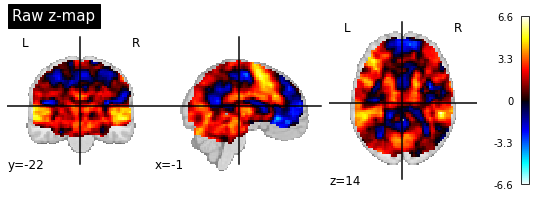

In [5]:
# compute group-level statistical map
design_matrix = pd.DataFrame([1] * n_samples, columns = ['intercept'])
second_level_model = SecondLevelModel().fit(
    cmap_filenames, design_matrix = design_matrix)
z_map = second_level_model.compute_contrast(output_type = 'z_score')
display = plotting.plot_stat_map(z_map, title = 'Raw z-map') # and plot

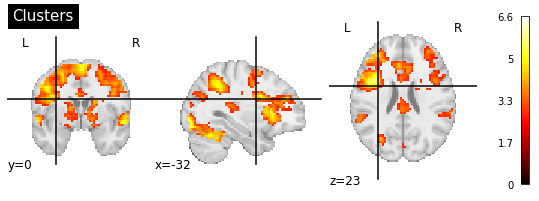

In [6]:
# show where stronger-than-chance clusters are
t_obs, clusters, cluster_pv, H0 = obs_stats[look_times[-1]]
sig_clusts = [clust for i, clust in enumerate(clusters) if cluster_pv[i] < adj_alpha[-1]]
cluster_mask = np.any(np.stack(sig_clusts), axis = 0)
masked_z_map = Nifti1Image(z_map.get_fdata() * cluster_mask, z_map.affine)
display = plotting.plot_stat_map(masked_z_map, title = 'Clusters')